# Heatmap compsoed model
 - heatmap-edge2.pth


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [2]:
import pickle

class HeatmapDataset(Dataset):
    """My dataset."""

    def __init__(self, pickle_path, transform=None, n_sample=None):
        super(HeatmapDataset, self).__init__()
        self.pickle_path = pickle_path
        self.transform = transform
        self.upsample = nn.UpsamplingBilinear2d([224,224])
        
        # load
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
            self.boxes_data = data['boxes'] # n_box, 4
            self.heatmap_data = data['heatmaps'] # cls,ch,h,w tensor
            self.origTargets = data['targets'] # 
            self.sobels = data['sobels'] # 1,224,224 tensor
            
#         # n개만 샘플링 - validation용
#         if(n_sample is not None):
#             sample_indices = np.random.choice(len(self.heatmap_data), n_sample, replace=False)
#             self.boxes_data = self.boxes_data[sample_indices]
#             self.heatmap_data = self.heatmap_data[sample_indices]
#             self.origTargets = self.origTargets[sample_indices]
#             self.sobels = self.sobels[sample_indices] 

        self.origTargetSet = list(set(np.concatenate(self.origTargets)))
        self.origTarget2newTarget = {t:i for i,t in enumerate(self.origTargetSet)}
        self.n_classes = len(self.origTarget2newTarget)
        assert len(self.heatmap_data)==len(self.boxes_data), "num_heatmap != num_box"

    def __len__(self):
        return len(self.heatmap_data)

    def __getitem__(self, idx):
        bboxes = torch.tensor(self.boxes_data[idx])
        targets = torch.tensor([self.origTarget2newTarget[t] for t in self.origTargets[idx]])
        sobels = torch.stack([self.sobels[idx]]*self.n_classes) # cls, 1, 224, 224
        
        heatmap = self.heatmap_data[idx][self.origTargetSet]
        heatmap = self.upsample(heatmap) # cls, ch, 224, 224 - 4d tensor
        heatmap = torch.cat([heatmap, sobels], dim=1) # cls, ch+1, 224, 224 - 4d tensor
        
        if self.transform:
            heatmap = self.transform(heatmap).unsqueeze(0)

        one_hot = torch.zeros(len(targets), self.n_classes)
        one_hot[torch.arange(len(targets)), targets] = 1
        return heatmap.float(), bboxes.float(), one_hot

In [3]:
pickle_path = 'heatmap_voc_multi_1203.pickle'
pickle_val_path = 'heatmap_voc_multi_1203_val.pickle'

my_dataset = HeatmapDataset(pickle_path)
my_dataset_val = HeatmapDataset(pickle_val_path)#, n_sample=100)


my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)
my_loader_val = torch.utils.data.DataLoader(my_dataset_val, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)


dataloaders = {
    'train': my_loader,
    'val': my_loader_val
}
dataset_sizes = {
    'train': len(my_dataset),
    'val': len(my_dataset_val)
}

print(dataset_sizes)

{'train': 7100, 'val': 284}


In [4]:
my_dataset[8][0].shape, my_dataset[8][1].shape, my_dataset[8][2], my_dataset.origTarget2newTarget

(torch.Size([11, 5, 224, 224]),
 torch.Size([1, 4]),
 tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 {0: 0, 1: 1, 2: 2, 6: 3, 7: 4, 9: 5, 11: 6, 12: 7, 13: 8, 16: 9, 18: 10})

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
        
class BoxMaker(nn.Module):
    def __init__(self):
        super(BoxMaker, self).__init__()
        global_average_pooling = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        
        # backbone layer
        self.backbone = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(5, 32, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # b*cls x 256 x 14 x 14
#             global_average_pooling, # n x 256 x 1 x 1
#             flatten, # n x 256
        )
        
        self.backbone2 = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(5, 32, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # b*cls x 256 x 14 x 14
#             global_average_pooling, # n x 256 x 1 x 1
#             flatten, # n x 256
        )
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8)
                        
        self.fc = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(512, 256, kernel_size=(1,1), stride=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.Conv2d(256, 5, kernel_size=(1,1), stride=(1, 1)),
            nn.BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),            
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        
    def forward(self, inputs):
        """
        inputs - 1,cls,ch,224,224
        디텍터는 한번에 한 프레임밖에 안됨
        """
        # CNN backbone
        images = inputs[0] # cls,ch,224,224
        
        hh = self.backbone(images) # cls x 256 x 14 x 14
        hh2 = self.backbone2(images) # cls x 256 x 14 x 14
        
        hh = hh.reshape(-1, 256, 196) # cls x 256 x 196
        hh2 = hh2.reshape(-1, 256, 196) # cls x 256 x 196
        
        hh3 = torch.cat([hh,hh2], dim=1) # cls x 512 x 196
        hh3 = hh3.transpose(1,2) # cls x 196 x 512
        
        attn_output, attn_output_weights = self.multihead_attn(hh3, hh3, hh3) # q,k,v - Seq,Batch,Embed - cls,196,512       
        attn_sum = hh3+attn_output # cls x 196 x 512
        
        res = attn_sum.transpose(1,2) # cls x 512 x 196

        res2 = res.reshape(-1,512, 14, 14) # cls x 512 x 14 x 14 - for conv 
        
        pp = self.fc(res2) # cls x 5(1+4) x 14 x 14
        pp = pp.transpose(2,1) # cls x 14 x 14 x 5(1+4)
        pp = pp.reshape(-1,196,5)
        logit = pp[:,:,0] # cls x 196
        coords = pp[:,:,1:] # cls x 196 x 4
        
        return logit, coords

In [6]:
from torchsummary import summary
model = BoxMaker()
model.to(model.device)
# summary(model, (2, 5, 224, 224))

BoxMaker(
  (roi_upsample): UpsamplingBilinear2d(size=[224, 224], mode=bilinear)
  (backbone): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

In [7]:
def IOU_loss(ious):
    """
    @params ious - N length tensor
    배치 하나당 0.3 정도가 약 0.5 IOU
    """
    loss = -1 * (ious +1e-9).log() 
    return loss.sum()

def cvt_yolobox_tensor(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,x2,y2
    """
    bboxes = bboxes_yolo.clone() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1] + bboxes[:,0]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0] + bboxes[:,1]
    return bboxes

def yolo2xxyy(boxes_gt):
    # yolo box to (x1,y1,x2,y2)
    boxes_gt_xxyy = torch.rand_like(boxes_gt) # cx,cy,w,h
    boxes_gt_xxyy[:,0] = boxes_gt[:,0] - boxes_gt[:,2]/2
    boxes_gt_xxyy[:,1] = boxes_gt[:,1] - boxes_gt[:,3]/2
    boxes_gt_xxyy[:,2] = boxes_gt[:,0] + boxes_gt[:,2]/2
    boxes_gt_xxyy[:,3] = boxes_gt[:,1] + boxes_gt[:,3]/2
    return boxes_gt_xxyy # x1,y1,x2,y2

# make 14x14 center coords
x_range = np.linspace(0,1,14+1)
X, Y = np.meshgrid(x_range,x_range)
C = np.array([list(zip(x, y)) for x, y in zip(X, Y)])
EDGES = C[:14,:14].reshape(-1,2)

CC = []
for x in range(C.shape[0]-1):
    for y in range(C.shape[1]-1):
        CC.append((C[x][y]+C[x+1][y+1])/2) # x1,y1,x2,y2
CENTERS = np.array(CC)
INTERVAL = 1/14

criterion_logit = nn.BCEWithLogitsLoss(reduction='mean') # N x cls (one-hot)
def criterion_coord(boxes_pred, boxes_gt, weights=None):
    """
    boxes - N x 4 :  cx,cy,w,h (normalized like Yolo data)
    weights - N
    """
    # bbox coord loss
    _loss = (boxes_pred-boxes_gt).pow(2)
    if(weights is not None):
        _weight = weights.repeat([4,1]).transpose(0,1) # N x 4
        _loss = _loss * _weight
    
    loss_xy = _loss[:,:2] *1000
    loss_wh = _loss[:, 2:] *100 
    return loss_xy.mean(), loss_wh.mean()

In [8]:
import time 
import copy

from tensorboardX import SummaryWriter
writer = SummaryWriter()

def train_model(model, criterion_logit, criterion_coord, optimizer, num_epochs=25):
    global loss_list_train, loss_list_val, best_model_wts

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    prev_val_loss = float('inf')
    val_cnt = 0 # val loss 커진 횟수
    decrease_cnt = 0 # lr 줄인 횟수

    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_logit = 0.0
            running_loss_xy = 0.0
            running_loss_wh = 0.0
            running_corrects = 0
            # Iterate over data.
            for idx, (heatmap, boxes_gt, targets_gt) in enumerate(dataloaders[phase]):
                heatmap = heatmap.to(model.device) # 1 x cls x ch x 224 x 224 
                boxes_gt = boxes_gt[0].to(model.device) # n x 4
                targets_gt = targets_gt[0].to(model.device) # n x cls

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    logits, boxes_pred = model(heatmap)
                    boxes_pred_selected = boxes_pred[boxes_gt.argmax(dim=1)] # 모델이 예측한 값중 정답 클래스의 박스값들

                    # mask, weight 생성
                    masks = []
                    weights = []
                    boxes_gt_xxyy = yolo2xxyy(boxes_gt)
                    for i in range(len(boxes_gt)):
                        mask = (EDGES[:,0]>boxes_gt_xxyy[i][0].item()-INTERVAL)&(EDGES[:,0]<=boxes_gt_xxyy[i][2].item())&(EDGES[:,1]>boxes_gt_xxyy[i][1].item()-INTERVAL)&(EDGES[:,1]<=boxes_gt_xxyy[i][3].item())
                        weight = np.apply_along_axis(lambda c: (1 - np.linalg.norm(c-boxes_gt[i][:2].cpu().numpy())), 1, CENTERS)
                        masks.append(mask)
                        weights.append(weight)
                    masks = torch.tensor(masks).to(model.device)
                    weights = torch.tensor(weights).pow(4).cuda(model.device) # 거리 4제곱 반비례 [0~1]

                    loss = torch.tensor(0).double().cuda()
                    for i in range(len(targets_gt)):
                        # 동적으로 가중치 변경해가며 BCE loss
                        loss_logit = torch.tensor(0).double().cuda()
                        for p,g,w in zip(logits[:, masks[i]].transpose(0,1), targets_gt[i].repeat(masks.sum(dim=1)[i],1), weights[i][masks[i]]):
                            l = criterion_logit(p,g)*w
                            loss_logit += l
                        loss_xy, loss_wh = criterion_coord(boxes_pred_selected[i][masks[i]], boxes_gt[i].repeat(masks.sum(dim=1)[i],1), weights[i][masks[i]])
                        loss = loss + loss_logit +loss_xy + loss_wh
#                         print('[]',loss_logit.dtype, loss_xy.dtype, loss_wh.dtype)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.float().backward()
                        optimizer.step()

                # statistics
                running_loss_logit += loss_logit.item()
                running_loss_xy += loss_xy.item()
                running_loss_wh += loss_wh.item()
                running_loss += loss.item()
                
                # mini batch statistics
                if idx>0 and idx%100==0:
                    cnt = idx*dataloaders[phase].batch_size
                    print('[batch]{}, {} Loss_l: {:.4f}, Loss_xy: {:.4f}, Loss_wh: {:.4f}, Acc: {:.4f}'.format(
                        cnt, phase, running_loss_logit/cnt, running_loss_xy/cnt, running_loss_wh/cnt, running_corrects/cnt))
#                     writer.add_scalar('loss_%s/loss_logit'%phase, running_loss_logit/cnt, cnt+epoch*dataset_sizes[phase])
#                     writer.add_scalar('loss_%s/loss_xy'%phase, running_loss_xy/cnt, cnt+epoch*dataset_sizes[phase])
#                     writer.add_scalar('loss_%s/loss_wh'%phase, running_loss_wh/cnt, cnt+epoch*dataset_sizes[phase])
#                     writer.add_scalar('loss_%s/loss_all'%phase, running_loss/cnt, cnt+epoch*dataset_sizes[phase])
                    writer.add_scalars('loss_%s/loss_logit'%phase, {'Loss':running_loss_logit/cnt}, cnt+epoch*dataset_sizes[phase])
                    writer.add_scalars('loss_%s/loss_xy'%phase, {'Loss':running_loss_xy/cnt}, cnt+epoch*dataset_sizes[phase])
                    writer.add_scalars('loss_%s/loss_wh'%phase, {'Loss':running_loss_wh/cnt}, cnt+epoch*dataset_sizes[phase])
                    writer.add_scalars('loss_%s/loss_all'%phase, {'Loss':running_loss/cnt}, cnt+epoch*dataset_sizes[phase])

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            # detail
            loss_xy_list[phase].append(running_loss_xy/dataset_sizes[phase])
            loss_wh_list[phase].append(running_loss_wh/dataset_sizes[phase])
            loss_logit_list[phase].append(running_loss_logit/dataset_sizes[phase])       
            writer.add_scalars('epoch_loss_%s/loss_xy'%phase, {'Loss':running_loss_xy/dataset_sizes[phase]}, epoch)
            writer.add_scalars('epoch_loss_%s/loss_wh'%phase, {'Loss':running_loss_xy/dataset_sizes[phase]}, epoch)
            writer.add_scalars('epoch_loss_%s/loss_logit'%phase, {'Loss':running_loss_xy/dataset_sizes[phase]}, epoch)
            writer.add_scalars('epoch_loss_%s/loss_all'%phase, {'Loss':running_loss/dataset_sizes[phase]}, epoch)


            # all
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc)

            print('{} Loss: {:.4f}, Acc: {:.4f}, lr: {}, BestLoss: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr'], best_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
                # save model
                torch.save(model.state_dict(), 'torch_models/heatmap-5chan-multi-1204-%d.pth'%epoch)
                
#             # for lr decay
#             if phase == 'val' and epoch_loss < prev_val_loss:
                val_cnt = 0                
            elif phase == 'val' and epoch_loss >= best_loss:
                val_cnt += 1
            
            if phase == 'val':
                prev_val_loss = epoch_loss
                
        # decay 0.2 per 2 chance        
        if(val_cnt==1):  # 2번 안내려가면 러닝레이트 내림
            val_cnt = 0
            decrease_cnt += 1
            for g in optimizer.param_groups:
                g['lr'] = g['lr']*0.2
                print('****** lr decrease ******')
                print('[decrease_cnt]:', decrease_cnt, ', [lr]:', g['lr'])
                print('[Load best weight]')
                model.load_state_dict(best_model_wts)
                
        if(decrease_cnt==5): # 학습 멈춤
            print('###### early stop #####')
            break
            

        time_elapsed = time.time() - since
        print('Training epoch duration is {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model.load_state_dict(torch.load('torch_models/heatmap-5chan-multi-1204-10.pth'))

<All keys matched successfully>

In [11]:
loss_xy_list = {'train':[], 'val':[]}
loss_wh_list = {'train':[], 'val':[]}
loss_logit_list = {'train':[], 'val':[]}

loss_list = {'train':[], 'val':[]}
acc_list = {'train':[], 'val':[]}
best_model_wts = None

# Observe that only parameters of final layer are bkeing optimized as
# optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 3 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [12]:
# Set seed
torch.manual_seed(777)
model = train_model(model, criterion_logit, criterion_coord, optimizer, num_epochs=50)

Epoch 1/50
----------
[batch]100, train Loss_l: 21.7531, Loss_xy: 94.4812, Loss_wh: 11.2319, Acc: 0.0000
[batch]200, train Loss_l: 19.6686, Loss_xy: 93.0441, Loss_wh: 10.0789, Acc: 0.0000
[batch]300, train Loss_l: 19.6456, Loss_xy: 82.7237, Loss_wh: 9.1267, Acc: 0.0000
[batch]400, train Loss_l: 19.2250, Loss_xy: 78.3446, Loss_wh: 8.7839, Acc: 0.0000
[batch]500, train Loss_l: 19.2608, Loss_xy: 74.3768, Loss_wh: 8.5205, Acc: 0.0000
[batch]600, train Loss_l: 19.2358, Loss_xy: 69.2495, Loss_wh: 8.2079, Acc: 0.0000
[batch]700, train Loss_l: 19.5375, Loss_xy: 64.4093, Loss_wh: 7.8910, Acc: 0.0000
[batch]800, train Loss_l: 19.6709, Loss_xy: 59.4708, Loss_wh: 7.6029, Acc: 0.0000
[batch]900, train Loss_l: 19.7009, Loss_xy: 55.3856, Loss_wh: 7.3176, Acc: 0.0000
[batch]1000, train Loss_l: 19.7372, Loss_xy: 51.8805, Loss_wh: 7.1121, Acc: 0.0000
[batch]1100, train Loss_l: 19.6239, Loss_xy: 49.2208, Loss_wh: 6.9213, Acc: 0.0000
[batch]1200, train Loss_l: 19.6475, Loss_xy: 47.0144, Loss_wh: 6.7619, A

[batch]5000, train Loss_l: 19.7214, Loss_xy: 9.4426, Loss_wh: 4.3712, Acc: 0.0000
[batch]5100, train Loss_l: 19.6807, Loss_xy: 9.4929, Loss_wh: 4.3840, Acc: 0.0000
[batch]5200, train Loss_l: 19.6593, Loss_xy: 9.5187, Loss_wh: 4.3999, Acc: 0.0000
[batch]5300, train Loss_l: 19.6691, Loss_xy: 9.4805, Loss_wh: 4.3976, Acc: 0.0000
[batch]5400, train Loss_l: 19.6915, Loss_xy: 9.5003, Loss_wh: 4.3929, Acc: 0.0000
[batch]5500, train Loss_l: 19.6462, Loss_xy: 9.5196, Loss_wh: 4.3904, Acc: 0.0000
[batch]5600, train Loss_l: 19.6551, Loss_xy: 9.5780, Loss_wh: 4.3921, Acc: 0.0000
[batch]5700, train Loss_l: 19.6684, Loss_xy: 9.5716, Loss_wh: 4.3844, Acc: 0.0000
[batch]5800, train Loss_l: 19.6724, Loss_xy: 9.5849, Loss_wh: 4.3923, Acc: 0.0000
[batch]5900, train Loss_l: 19.7090, Loss_xy: 9.5370, Loss_wh: 4.3832, Acc: 0.0000
[batch]6000, train Loss_l: 19.7180, Loss_xy: 9.5174, Loss_wh: 4.3764, Acc: 0.0000
[batch]6100, train Loss_l: 19.7258, Loss_xy: 9.5013, Loss_wh: 4.3714, Acc: 0.0000
[batch]6200, tra

[batch]2600, train Loss_l: 19.6238, Loss_xy: 8.1484, Loss_wh: 4.1892, Acc: 0.0000
[batch]2700, train Loss_l: 19.5943, Loss_xy: 8.2227, Loss_wh: 4.1891, Acc: 0.0000
[batch]2800, train Loss_l: 19.6033, Loss_xy: 8.1975, Loss_wh: 4.1818, Acc: 0.0000
[batch]2900, train Loss_l: 19.6110, Loss_xy: 8.1286, Loss_wh: 4.1682, Acc: 0.0000
[batch]3000, train Loss_l: 19.5985, Loss_xy: 8.0615, Loss_wh: 4.1579, Acc: 0.0000
[batch]3100, train Loss_l: 19.5650, Loss_xy: 8.0345, Loss_wh: 4.1675, Acc: 0.0000
[batch]3200, train Loss_l: 19.5140, Loss_xy: 8.0637, Loss_wh: 4.1661, Acc: 0.0000
[batch]3300, train Loss_l: 19.4586, Loss_xy: 8.0683, Loss_wh: 4.1612, Acc: 0.0000
[batch]3400, train Loss_l: 19.4632, Loss_xy: 8.0643, Loss_wh: 4.1495, Acc: 0.0000
[batch]3500, train Loss_l: 19.4217, Loss_xy: 8.0142, Loss_wh: 4.1445, Acc: 0.0000
[batch]3600, train Loss_l: 19.4270, Loss_xy: 7.9566, Loss_wh: 4.1544, Acc: 0.0000
[batch]3700, train Loss_l: 19.4475, Loss_xy: 7.9202, Loss_wh: 4.1549, Acc: 0.0000
[batch]3800, tra

[decrease_cnt]: 3 , [lr]: 8.000000000000002e-07
[Load best weight]
Training epoch duration is 37m 34s
Epoch 9/50
----------
[batch]100, train Loss_l: 19.3819, Loss_xy: 6.8668, Loss_wh: 4.0618, Acc: 0.0000
[batch]200, train Loss_l: 19.7441, Loss_xy: 8.1614, Loss_wh: 3.9134, Acc: 0.0000
[batch]300, train Loss_l: 19.5995, Loss_xy: 7.9491, Loss_wh: 4.0435, Acc: 0.0000
[batch]400, train Loss_l: 20.0654, Loss_xy: 8.1363, Loss_wh: 3.9417, Acc: 0.0000
[batch]500, train Loss_l: 20.2260, Loss_xy: 7.7627, Loss_wh: 4.0268, Acc: 0.0000
[batch]600, train Loss_l: 20.2482, Loss_xy: 7.5247, Loss_wh: 4.0551, Acc: 0.0000
[batch]700, train Loss_l: 19.9326, Loss_xy: 7.4941, Loss_wh: 4.0492, Acc: 0.0000
[batch]800, train Loss_l: 20.0448, Loss_xy: 7.5292, Loss_wh: 3.9410, Acc: 0.0000
[batch]900, train Loss_l: 20.0214, Loss_xy: 7.3973, Loss_wh: 3.9804, Acc: 0.0000
[batch]1000, train Loss_l: 19.8541, Loss_xy: 7.4167, Loss_wh: 4.0172, Acc: 0.0000
[batch]1100, train Loss_l: 19.8225, Loss_xy: 7.6931, Loss_wh: 3.9

[batch]4900, train Loss_l: 19.5654, Loss_xy: 7.0270, Loss_wh: 4.0166, Acc: 0.0000
[batch]5000, train Loss_l: 19.5767, Loss_xy: 7.0072, Loss_wh: 4.0111, Acc: 0.0000
[batch]5100, train Loss_l: 19.5880, Loss_xy: 7.0200, Loss_wh: 4.0214, Acc: 0.0000
[batch]5200, train Loss_l: 19.5728, Loss_xy: 7.0247, Loss_wh: 4.0121, Acc: 0.0000
[batch]5300, train Loss_l: 19.5526, Loss_xy: 7.0398, Loss_wh: 4.0068, Acc: 0.0000
[batch]5400, train Loss_l: 19.5748, Loss_xy: 7.0965, Loss_wh: 4.0148, Acc: 0.0000
[batch]5500, train Loss_l: 19.5392, Loss_xy: 7.1151, Loss_wh: 4.0218, Acc: 0.0000
[batch]5600, train Loss_l: 19.5668, Loss_xy: 7.1014, Loss_wh: 4.0125, Acc: 0.0000
[batch]5700, train Loss_l: 19.5612, Loss_xy: 7.0960, Loss_wh: 4.0074, Acc: 0.0000
[batch]5800, train Loss_l: 19.5812, Loss_xy: 7.1014, Loss_wh: 4.0089, Acc: 0.0000
[batch]5900, train Loss_l: 19.5916, Loss_xy: 7.1072, Loss_wh: 4.0089, Acc: 0.0000
[batch]6000, train Loss_l: 19.5766, Loss_xy: 7.0850, Loss_wh: 4.0140, Acc: 0.0000
[batch]6100, tra

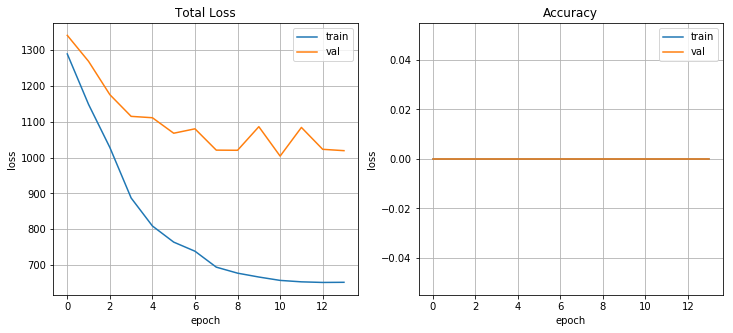

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_list['train'], label='train')
plt.plot(loss_list['val'], label='val')
plt.legend(loc='upper right')
plt.title('Total Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.subplot(1,2,2)
plt.plot(acc_list['train'], label='train')
plt.plot(acc_list['val'], label='val')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

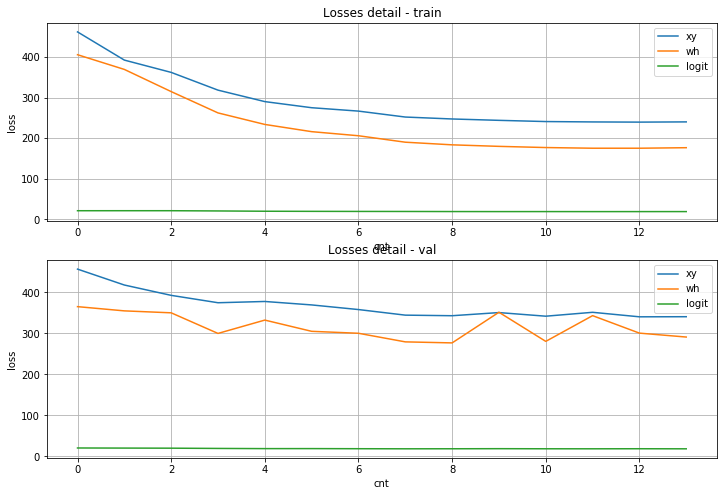

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(loss_xy_list['train'], label='xy')
plt.plot(loss_wh_list['train'], label='wh')
plt.plot(loss_logit_list['train'], label='logit')
plt.legend(loc='upper right')
plt.title('Losses detail - train')
plt.xlabel('cnt')
plt.ylabel('loss')
plt.grid()

plt.subplot(2,1,2)
plt.plot(loss_xy_list['val'], label='xy')
plt.plot(loss_wh_list['val'], label='wh')
plt.plot(loss_logit_list['val'], label='logit')
plt.legend(loc='upper right')
plt.title('Losses detail - val')
plt.xlabel('cnt')
plt.ylabel('loss')
plt.grid()
plt.show()

In [12]:
model.eval()
torch.save(model.state_dict(), 'torch_models/heatmap-5chan-multi-1204.pth')

---
# Test

In [9]:
import matplotlib.patches as patches

my_loader_test = torch.utils.data.DataLoader(my_dataset_val, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)

loader = iter(my_loader_test)
model.eval()

def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

# Calc IOU
def calcIOU(box1, box2):
    """
    box - x,y,w,h
    """
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def box_cvt(box):
    """
    auto grad possable
    @params box - N x 4
    x,y,w,h --> x1,y1,x2,y2
    """
    box2 = box.clone().float()
    box2[:,0] = box[:,0]
    box2[:,1] = box[:,1]
    box2[:,2] = box[:,0] + box[:,2]
    box2[:,3] = box[:,1] + box[:,3]
    return box2

[AREA gt] [0.05425301]
[Target]: aeroplane
[n_gt_box]: 0 [n_adj_box]: 14
[NMS]: 4


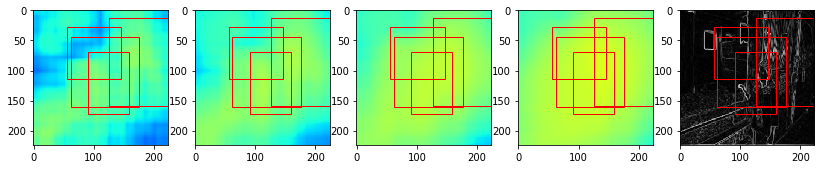

[Target]: bicycle
[n_gt_box]: 0 [n_adj_box]: 13
[NMS]: 5


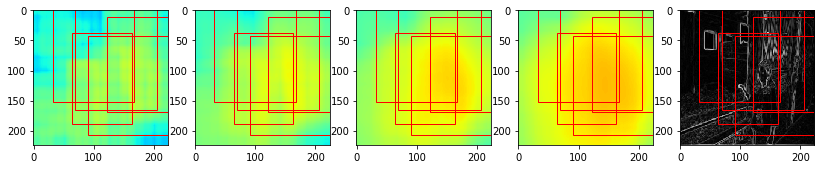

[Target]: bird
[n_gt_box]: 0 [n_adj_box]: 13
[NMS]: 2


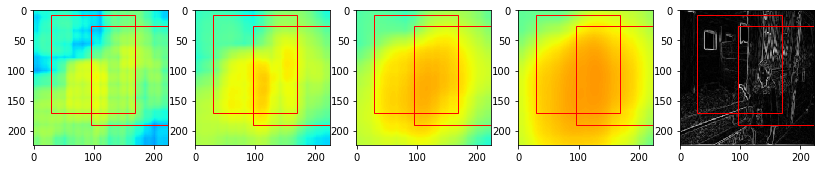

[Target]: car
[n_gt_box]: 0 [n_adj_box]: 13
[NMS]: 3


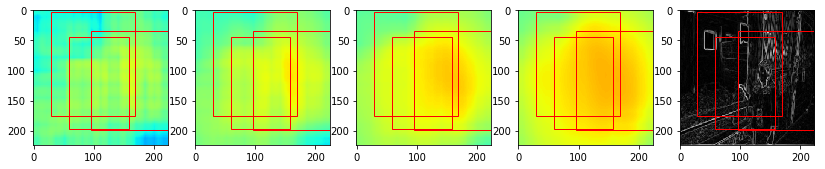

[Target]: cat
[n_gt_box]: 0 [n_adj_box]: 12
[NMS]: 2


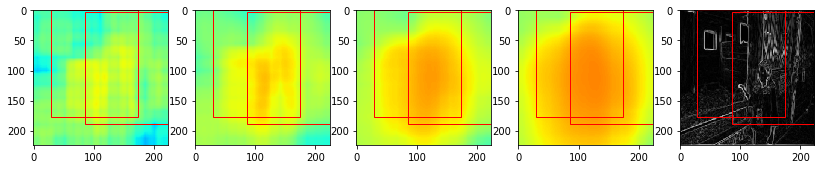

[Target]: cow
[n_gt_box]: 1 [n_adj_box]: 12
[NMS]: 2


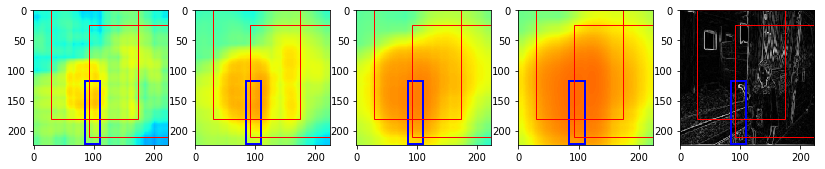

[Target]: dog
[n_gt_box]: 0 [n_adj_box]: 14
[NMS]: 2


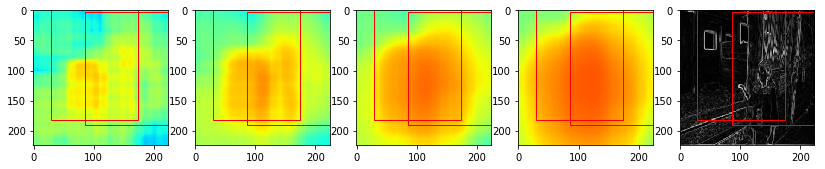

[Target]: horse
[n_gt_box]: 0 [n_adj_box]: 14
[NMS]: 2


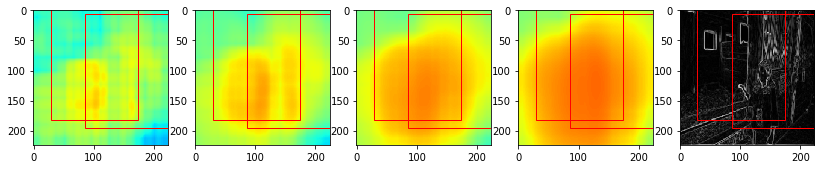

[Target]: motorbike
[n_gt_box]: 0 [n_adj_box]: 12
[NMS]: 4


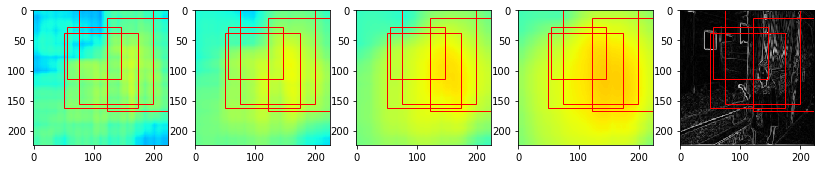

[Target]: sheep
[n_gt_box]: 0 [n_adj_box]: 13
[NMS]: 3


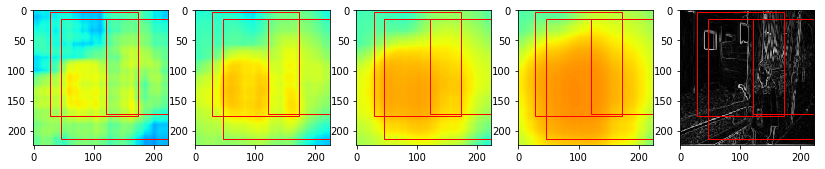

[Target]: train
[n_gt_box]: 0 [n_adj_box]: 13
[NMS]: 2


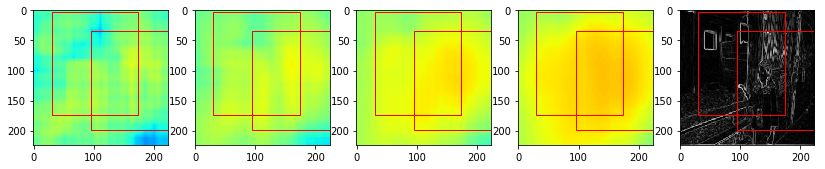

In [19]:
classes = ['aeroplane', 'bicycle', 'bird', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train']
heatmap, boxes_gt, targets = loader.next()
boxes_gt = boxes_gt.cpu().numpy()[0]
targets = targets[0]
print('[AREA gt]', boxes_gt[:,2]*boxes_gt[:,3])
boxes_gt = cvt_yolobox(boxes_gt, heatmap[0].shape[-2:])
logits, boxes_pred = model(heatmap.to(model.device))
logits = logits.sigmoid()

# 정답 박스값 가져오기
# box_dict= {t:{'gt':[], 'adj':[]} for t in set(targets.argmax(dim=1).numpy())}
box_dict= {t:{'gt':[], 'adj':[]} for t in range(targets.shape[-1])} # 모든 클래스에 대해 일단 생성
for t,b in zip(targets.argmax(dim=1).numpy(), boxes_gt):
    box_dict[t]['gt'].append(b)
box_dict[t]['gt'] = np.array(box_dict[t]['gt'])

# 모델 예측 박스값 가져오기
threshold = 0.7
for idx, cnt in enumerate((logits>threshold).sum(dim=1)):
    if(cnt>0):
#         boxes_adj = boxes_pred[idx][logits[idx].data.cpu().numpy()>threshold].data
        logits_adj = logits[idx][logits[idx]>threshold].data
        boxes_adj = cvt_yolobox(boxes_pred[idx][logits[idx]>threshold].data.cpu().numpy(), 
                                heatmap.shape[-2:])
        box_dict[idx]['adj'] = boxes_adj
        box_dict[idx]['logits'] = logits_adj
       
        
# ------------ Display the image and GT boxes ------------
for t in box_dict: # 프레임 내의 개별 target 개수로 반복
    if(len(box_dict[t]['adj'])==0 and len(box_dict[t]['gt'])==0): continue # gt, pred모두 하나도 없으면 넘기기
    print('[Target]:', classes[t])
    print('[n_gt_box]:', len(box_dict[t]['gt']), '[n_adj_box]:', len(box_dict[t]['adj']))
    imgs = heatmap[0][t]

    box_nms = []
    if(len(box_dict[t]['adj'])>0): # pred box가 있을때만
        # NMS
        bbb = torch.tensor(box_dict[t]['adj']).float() # N x 4 (x1,x2,y1,y2)로 들어가야해서 box_cvt적용
        sss = box_dict[t]['logits'].cpu()
        keeps = torchvision.ops.nms(box_cvt(bbb), sss, iou_threshold=0.5)
        print('[NMS]:', len(keeps))
        box_nms = bbb[keeps]
            
    # Create figure and axes
    fig = plt.figure(figsize=(14,4))
    for i in range(5):
        ax = fig.add_subplot(1,5, i+1)
        if(i==4): imgplot = ax.imshow(imgs[i].cpu(), cmap='gray')
        else: 
            imgplot = ax.imshow(imgs[i].cpu(), cmap='jet')
            imgplot.set_clim(0,1)

        # Create GT Rectangle patch
        for x1,y1,w1,h1 in box_dict[t]['gt']:
            rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            
        # Create pred_adj Rectangle patch
#         for x1,y1,w1,h1 in box_dict[t]['adj']:
        for x1,y1,w1,h1 in box_nms:
            rect = patches.Rectangle((x1,y1),w1,h1, linewidth=1,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)        
    plt.show()

In [332]:
t = 0
bbb = torch.tensor(box_dict[t]['adj']).float() # N x 4
sss = box_dict[t]['logits'].cpu()
keeps = torchvision.ops.nms(box_cvt(bbb), sss, iou_threshold=0.5)
print(keeps)
bbb[keeps]

tensor([39, 44, 20, 30,  8,  7, 27, 25, 21, 26, 16, 22, 35])


tensor([[ 76.,  67., 138., 152.],
        [ 53.,  61., 185., 233.],
        [ 59.,  83.,  83.,  59.],
        [ 71.,  77.,  99.,  91.],
        [ 70.,  24.,  70., 102.],
        [ 74.,   4.,  86., 153.],
        [ 49.,  65.,  95., 115.],
        [ 91.,  78.,  50.,  32.],
        [ 88.,  87.,  56.,  36.],
        [ 38.,  76.,  62.,  83.],
        [ 43.,  52.,  73.,  81.],
        [ 91., 102.,  83.,  42.],
        [ 97., 103., 103.,  87.]])

In [331]:
box_dict

{0: {'adj': array([[ 69, -11,  94, 166],
         [ 41,  14, 142, 165],
         [ 64,  24,  69,  87],
         [ 83,   5,  83, 145],
         [ 77,   6,  86, 133],
         [ 76,  -4,  93, 161],
         [ 71,  38,  62,  81],
         [ 74,   4,  86, 153],
         [ 70,  24,  70, 102],
         [ 83,  19,  92, 147],
         [ 60,  40,  81, 110],
         [ 60,  55,  79, 102],
         [ 54,  34,  88, 104],
         [ 56,  79, 107,  81],
         [ 86,  66,  86, 122],
         [ 62,  38,  79,  99],
         [ 43,  52,  73,  81],
         [ 67,  69,  77,  75],
         [ 68,  72,  90,  58],
         [ 61,  65,  71,  93],
         [ 59,  83,  83,  59],
         [ 88,  87,  56,  36],
         [ 91, 102,  83,  42],
         [ 58,  58,  59,  81],
         [ 64,  73,  70,  70],
         [ 91,  78,  50,  32],
         [ 38,  76,  62,  83],
         [ 49,  65,  95, 115],
         [ 71,  74,  85,  66],
         [ 43,  48, 111, 156],
         [ 71,  77,  99,  91],
         [ 52,  62,  96, 124]

In [289]:
idx=0
print(logits[idx]>threshold)
print(boxes_pred[idx][logits[idx]>threshold].data.cpu().numpy())
print(logits[idx][logits[idx]>threshold].data.sigmoid())

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False,  True, False, False,  True, False, False, False, False, False,
        False, False, False, False, False,  True, False, False,  True, False,
        False,  True, False, False, False, False, False, False, False,  True,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False,  True, False, False,  True, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False,  True, False, False,  True, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [ ]:
torchvision.ops.nms()

In [284]:
print(targets)
print((logits>threshold).sum(dim=1))
print((logits.reshape(-1,14,14).detach().cpu().numpy()[1]>0.5).astype(int))
print((logits.reshape(-1,14,14).detach().cpu().numpy()[6]>0.5).astype(int))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
[[0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [72]:
# target.argmax(dim=1)
# imgplot.shape
heatmap[0][targets.argmax(dim=1)].shape, targets.argmax(dim=1)

(torch.Size([4, 5, 224, 224]), tensor([8, 1, 8, 1]))

In [216]:
boxes_gt, box_adj.shape, logits.shape

(array([[  0,  41, 150, 121]]),
 torch.Size([11, 196, 4]),
 torch.Size([11, 196]))

In [112]:
(logits>threshold).sum(dim=1), boxes_pred[1][logits[1].data.cpu().numpy()>threshold].data

(tensor([ 0, 11,  0,  0,  0,  0,  0,  0, 39,  0,  0], device='cuda:0'),
 tensor([[0.3966, 0.4761, 0.2731, 0.1923],
         [0.5559, 0.4112, 0.6320, 0.5722],
         [0.4944, 0.5416, 0.6237, 0.5749],
         [0.5604, 0.5381, 0.6472, 0.6409],
         [0.6320, 0.5178, 0.5782, 0.4121],
         [0.6642, 0.4720, 0.5024, 0.5107],
         [0.4879, 0.5907, 0.6450, 0.6133],
         [0.6258, 0.5865, 0.6486, 0.5425],
         [0.6909, 0.4584, 0.4952, 0.5936],
         [0.4797, 0.5835, 0.6464, 0.6307],
         [0.6697, 0.5090, 0.5383, 0.5765]], device='cuda:0'))

In [158]:
targets.argmax(dim=1).numpy(), boxes_gt, set(targets.argmax(dim=1).numpy())

(array([8, 1, 8, 1], dtype=int64), array([[123,  57,  93, 142],
        [141,  11,  47,  20],
        [ 57,  26,  98,  43],
        [126,  17,  20,  17]]), {1, 8})

[Target]: 6


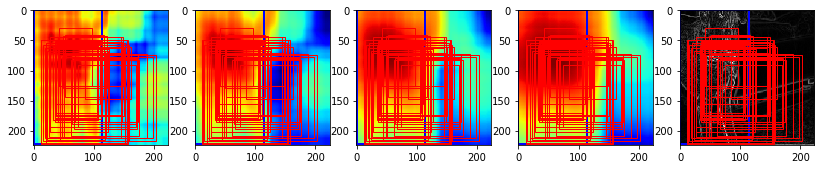

In [205]:
# 정답 박스값 가져오기
box_dict= {t:{'gt':[], 'adj':[]} for t in set(targets.argmax(dim=1).numpy())}
for t,b in zip(targets.argmax(dim=1).numpy(), boxes_gt):
    box_dict[t]['gt'].append(b)
box_dict[t]['gt'] = np.array(box_dict[t]['gt'])

# 모델 예측 박스값 가져오기
threshold = 0.8
for idx, cnt in enumerate((logits>threshold).sum(dim=1)):
    if(cnt>0):
#         boxes_adj = boxes_pred[idx][logits[idx].data.cpu().numpy()>threshold].data
        boxes_adj = cvt_yolobox(boxes_pred[idx][logits[idx]>threshold].data.cpu().numpy(), 
                                heatmap.shape[-2:])
        box_dict[idx]['adj'] = boxes_adj
        
# Display the image and GT boxes
for t in box_dict: # 프레임 내의 개별 target 개수로 반복
    print('[Target]:', t)
    imgs = heatmap[0][t]
#     x1,y1,w1,h1 = boxes_gt[idx]

    # Create figure and axes
    fig = plt.figure(figsize=(14,4))
    for i in range(5):
        ax = fig.add_subplot(1,5, i+1)
        if(i==4): imgplot = ax.imshow(imgs[i].cpu(), cmap='gray')
        else: 
            imgplot = ax.imshow(imgs[i].cpu(), cmap='jet')
        #     imgplot.set_clim(0,1)

        # Create GT Rectangle patch
        for x1,y1,w1,h1 in box_dict[t]['gt']:
            rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            
        # Create pred_adj Rectangle patch
        for x1,y1,w1,h1 in box_dict[t]['adj']:
            rect = patches.Rectangle((x1,y1),w1,h1, linewidth=1,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)        
    plt.show()

In [26]:
heatmap.shape, box.shape, logit.shape, box_adj.shape

(torch.Size([1, 11, 5, 224, 224]),
 (1, 4),
 torch.Size([11, 196]),
 torch.Size([11, 196, 4]))

[AREA gt]: 0.0791
[IOU]: 0.3579
True [Pred]: 0 [GT]: 0


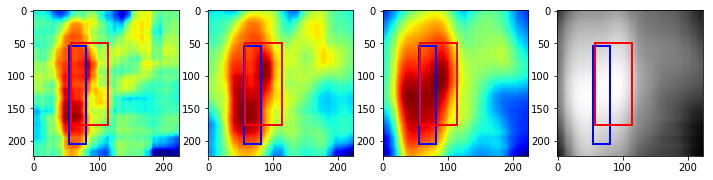

In [17]:
heatmap, box, target = loader.next()
box = box.cpu().numpy() 
print('[AREA gt]: {:.4f}'.format(box[0][2]*box[0][3]))
box = cvt_yolobox(box, heatmap.shape[-2:])
x1,y1,w1,h1 = box[0]
logit, box_adj = model(heatmap.to(model.device))
_, pred = torch.max(logit, 1)
__, label = torch.max(target, 1)
box_adj = cvt_yolobox(box_adj[:,pred.item()].detach().cpu().numpy(), heatmap.shape[-2:])
x2,y2,w2,h2 = box_adj[0]
print('[IOU]: {:.4f}'.format(calcIOU(box[0], box_adj[0])))
print(pred.item()==label.item(), '[Pred]:', pred.item(), '[GT]:', label.item())

# Create figure and axes
fig = plt.figure(figsize=(12,12))

# Display the image
for i in range(4):
    ax = fig.add_subplot(1,4, i+1)
    if(i==3): imgplot = ax.imshow(heatmap[0][pred.item()][i].cpu(), cmap='gray')
    else: 
        imgplot = ax.imshow(heatmap[0][pred.item()][i].cpu(), cmap='jet')
    #     imgplot.set_clim(0,1)

    # Create a Rectangle patch
    rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
    rect_pred = patches.Rectangle((x2,y2),w2,h2, linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.add_patch(rect_pred)

plt.show()

A Jupyter Widget


[IOU summary]
count    135.000000
mean       0.405937
std        0.167748
min        0.000000
25%        0.295922
50%        0.402335
75%        0.527770
max        0.867620
dtype: float64
-----------------------------
[Acc]: 0.725925925925926
[Adjusted IOU mean]: 0.32924872412406037


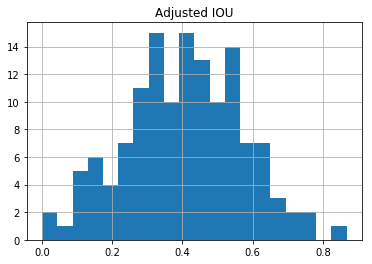

In [16]:
# show simple result
loader = iter(my_loader_test)
ious = []
labels = []
preds = []
areas_gt = []
areas_pred = []
for heatmap, box, target in tqdm(loader):
    box = box.cpu().numpy() 
    areas_gt.append(box[0][2]*box[0][3])
    box = cvt_yolobox(box, heatmap.shape[-2:])
    x1,y1,w1,h1 = box[0]
    logit, box_adj = model(heatmap.to(model.device))
    _, pred = torch.max(logit, 1)
    __, label = torch.max(target, 1)
    areas_pred.append((box_adj[0][pred.item()][2]*box_adj[0][pred.item()][3]).item())
    box_adj = cvt_yolobox(box_adj[:,pred.item()].detach().cpu().numpy(), heatmap.shape[-2:])
    x2,y2,w2,h2 = box_adj[0]
    ious.append(calcIOU(box[0], box_adj[0]))
    preds.append(pred.item())
    labels.append(label.item())
    
preds = np.array(preds)
labels = np.array(labels)
ious = np.array(ious)

areas_gt = pd.Series(areas_gt)
areas_pred = pd.Series(areas_pred)
summary = pd.Series(ious)
print('[IOU summary]')
print(summary.describe())
print('-----------------------------')
mask = preds == labels
print('[Acc]:', mask.mean())
print('[Adjusted IOU mean]:', ious[mask].sum()/len(mask))
plt.title('Adjusted IOU')
summary.hist(bins=20)
plt.show()

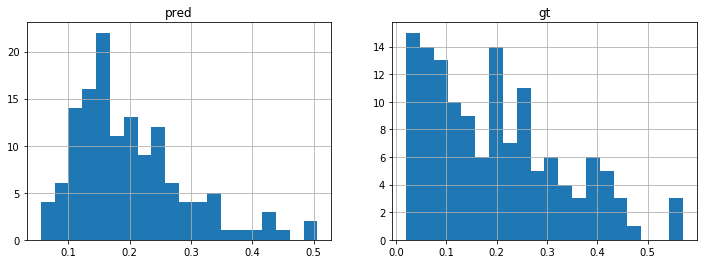

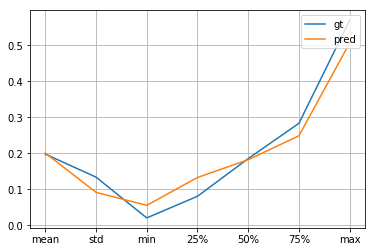

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('pred')
areas_pred.hist(bins=20)
plt.subplot(1,2,2)
plt.title('gt')
areas_gt.hist(bins=20)
plt.show()

plt.plot(areas_gt.describe()[1:], label='gt')
plt.plot(areas_pred.describe()[1:], label='pred')
plt.grid()
plt.legend(loc='upper right')
plt.show()
# areas_gt.describe()